# CPSC 585 - Artificial Neural Networks

Group Project 2, Spring 2023

Professor: Kenytt Avery

**Group 9**
> * Devansh Sharma
> * Bike Qian
> * Uma Maddukuri
> * Michael Collins
> * Brijesh Prajapati
> * Parth Nilkanthrai Barot  





##Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import collections
import pathlib
from tensorflow.keras.layers import Embedding, SimpleRNN, Bidirectional, Dense, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from tensorflow.keras import layers, losses, utils
from tensorflow.keras.layers import TextVectorization

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

##Loading the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/My Drive/CPSC585/Project_2/RateMyProfessor_Sample data.csv')

# Filtering the required columns

data = data[['diff_index', 'comments', 'star_rating', 'student_star', 'student_difficult']]
print("Shape before dropping rows", data.shape)

# Dropping the rows with missing data if any are present

data = data.dropna()
print("Shape after dropping rows", data.shape)



Mounted at /content/drive
Shape before dropping rows (20000, 5)
Shape after dropping rows (19993, 5)


##Preprocessing the data



*   We have grouped the data into train and labels based on the attributes in the dataset
*   Applied pre processing techniques to remove punctuation and converted it into lower case words.



In [ ]:
x = data["comments"]
y_ss = data["student_star"]
y_sd=data['student_difficult']


In [ ]:
x=x.astype(str)

In [ ]:
import string

# converting text to lowercase

X_low=x.str.lower()
print(x[25])
print(X_low[25])

# Removing punctuations from the text

PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
  return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))
X_final = X_low.apply(lambda text: remove_punctuation(text))

print(X_final[25])


Wager is a great professor! She makes the class lively and is absolutely hilarious. I took the hybrid-block course. As long as you do the assignments on time it\'s an easy A. The only complaints I have are: a lot of the examples/ content is politically influenced (liberal) and she doesn\'t always describe assignments or what is expected of you well.
wager is a great professor! she makes the class lively and is absolutely hilarious. i took the hybrid-block course. as long as you do the assignments on time it\'s an easy a. the only complaints i have are: a lot of the examples/ content is politically influenced (liberal) and she doesn\'t always describe assignments or what is expected of you well.
wager is a great professor she makes the class lively and is absolutely hilarious i took the hybridblock course as long as you do the assignments on time its an easy a the only complaints i have are a lot of the examples content is politically influenced liberal and she doesnt always describe as

**Tokenization**



*   Initially we have created a tokenizer with a maximum number of words size = 10000
*   Then applied **fit_on_texts** method of tokenizer to the training data for creating tokens.
*   Finally converted the tokens into sequences for training








In [ ]:
# Setting maximum number of words in the vocabulary
vocab_size = 10000

# Create a tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')

# Fit the tokenizer on the training data
tokenizer.fit_on_texts(X_final)

# Convert text data to sequences
train_sequences = tokenizer.texts_to_sequences(X_final)


Padding the sequences

In [ ]:
# Set the maximum sequence length

max_length = 100

# Padding the sequences

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')



##GloVe Embedding



*   First we have loaded the glove text file which is of 100d dimension.
*   Then created the **embeddings_index** dictionary for storing the words and indexes
*   Later we have created the **embedded_matrix** for the word_index of tokenizer
*   Finally we have created the **embedding_layer** for the glove model





In [ ]:
embeddings_index = {}
with open("/content/drive/My Drive/CPSC585/Project_2/glove.6B.100d.txt") as f:
  for line in f:
    word, coefs = line.split(maxsplit = 1)
    coefs = np.fromstring(coefs, "f" ,sep = " ")
    embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))
# print(type(embeddings_index))

Found 400000 word vectors.


In [ ]:
word_index=tokenizer.word_index
num_tokens = len(word_index) + 1
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector # Words not found in embedding index will be all-zeros
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 13560 words (6437 misses)


In [ ]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

##Splitting into Training & Validation Datasets
Spliting the student star and comments data.


In [ ]:
X=np.array(train_padded)
X_train,X_val, Y_ss_train,Y_ss_val=train_test_split(X,y_ss, test_size=0.2, shuffle=True)

Spliting the student difficulty and comments data.

In [ ]:
X=np.array(train_padded)
X_train,X_val, Y_sd_train,Y_sd_val=train_test_split(X,y_sd, test_size=0.2, shuffle=True)

In [ ]:
X_train=tf.convert_to_tensor(X_train)
X_val=tf.convert_to_tensor(X_val)
Y_ss_train=tf.convert_to_tensor(Y_ss_train)
Y_ss_val=tf.convert_to_tensor(Y_ss_val)
Y_sd_train=tf.convert_to_tensor(Y_sd_train)
Y_sd_val=tf.convert_to_tensor(Y_sd_val)

One Hot encoding the Labels

In [ ]:
Y_ss_train=to_categorical(Y_ss_train, num_classes=9)
Y_ss_val=to_categorical(Y_ss_val, num_classes=9)
Y_sd_train=to_categorical(Y_sd_train, num_classes=9)
Y_sd_val=to_categorical(Y_sd_val, num_classes=9)

## Glove Model with Regression Approach


*   First we have added the prepared embedding layer to the model.
*   We have used 2 layers of Bidirectional RNN and LSTM in our architecture.
*   A dropout with 0.5 percent
*   We have used L2 regularizer to avoid overfitting of the model
*   List item
*   A dense layer with **1 neuron** for output with **linear** activation and **mean_squared_error** loss function
*   We have also used **adam** optimizer in the glove model






In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Input, Dropout, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers


glove_model_ss = keras.Sequential()
glove_model_ss.add(embedding_layer)
glove_model_ss.add(Bidirectional(LSTM(64, return_sequences=True)))
glove_model_ss.add(Bidirectional(LSTM(32)))
glove_model_ss.add(Dropout(0.5))
glove_model_ss.add(Dense(1, activation='linear', kernel_regularizer=regularizers.l2(0.001)))

glove_model_ss.summary()
from tensorflow.keras.optimizers import Adam
glove_model_ss.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy','mae'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         1999800   
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        84480     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 2,125,561
Trainable params: 125,761
Non-tr

**For Student Star Rating**

Here we are fitting the model for students star rating for the professors.

We have achieved an accuracy of **88.9%**, MAE score of **0.19**, and loss of **0.09** .

In [ ]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)

glove_model_ss.fit(X_train, Y_ss_train, validation_data=(X_val,Y_ss_val),
           epochs=10, batch_size=64, verbose = 1, callbacks= [es])

Epoch 1/10
250/250 [==============================] - 20s 29ms/step - loss: 0.1042 - accuracy: 0.8875 - mae: 0.1989 - val_loss: 0.1000 - val_accuracy: 0.8889 - val_mae: 0.1952
Epoch 2/10
250/250 [==============================] - 4s 17ms/step - loss: 0.1002 - accuracy: 0.8889 - mae: 0.1962 - val_loss: 0.0996 - val_accuracy: 0.8889 - val_mae: 0.1938
Epoch 3/10
250/250 [==============================] - 7s 26ms/step - loss: 0.0997 - accuracy: 0.8889 - mae: 0.1966 - val_loss: 0.0994 - val_accuracy: 0.8889 - val_mae: 0.1947
Epoch 4/10
250/250 [==============================] - 6s 25ms/step - loss: 0.0994 - accuracy: 0.8889 - mae: 0.1968 - val_loss: 0.0992 - val_accuracy: 0.8889 - val_mae: 0.1969
Epoch 5/10
250/250 [==============================] - 5s 19ms/step - loss: 0.0992 - accuracy: 0.8889 - mae: 0.1970 - val_loss: 0.0991 - val_accuracy: 0.8889 - val_mae: 0.1966
Epoch 6/10
250/250 [==============================] - 5s 20ms/step - loss: 0.0991 - accuracy: 0.8889 - mae: 0.1972 - val_los

GloVe architecture for student difficulty prediction using regression

In [ ]:
glove_model_sd = keras.Sequential()
glove_model_sd.add(embedding_layer)
glove_model_sd.add(Bidirectional(LSTM(64, return_sequences=True)))
glove_model_sd.add(Bidirectional(LSTM(32)))
glove_model_sd.add(Dropout(0.5))
glove_model_sd.add(Dense(1, activation='linear', kernel_regularizer=regularizers.l2(0.001)))

glove_model_sd.summary()
from tensorflow.keras.optimizers import Adam
glove_model_sd.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy','mae'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         1999800   
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 128)        84480     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,125,561
Trainable params: 125,761
Non-

**For Student Difficult Rating**

Here we are fitting the model for the students difficulty rating for the professors

We have achieved an accuracy of **88.9%**, , MAE score of **0.19**, and loss of **0.09** .

In [ ]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)

glove_model_sd.fit(X_train, Y_sd_train, validation_data=(X_val,Y_sd_val),
           epochs=15, batch_size=64, verbose = 1, callbacks= [es])

Epoch 1/15
250/250 [==============================] - 13s 27ms/step - loss: 0.1034 - accuracy: 0.8881 - mae: 0.1982 - val_loss: 0.0998 - val_accuracy: 0.8889 - val_mae: 0.1953
Epoch 2/15
250/250 [==============================] - 5s 18ms/step - loss: 0.1000 - accuracy: 0.8889 - mae: 0.1963 - val_loss: 0.0995 - val_accuracy: 0.8889 - val_mae: 0.1955
Epoch 3/15
250/250 [==============================] - 5s 19ms/step - loss: 0.0996 - accuracy: 0.8889 - mae: 0.1966 - val_loss: 0.0993 - val_accuracy: 0.8889 - val_mae: 0.1995
Epoch 4/15
250/250 [==============================] - 5s 21ms/step - loss: 0.0994 - accuracy: 0.8889 - mae: 0.1969 - val_loss: 0.0992 - val_accuracy: 0.8889 - val_mae: 0.1960
Epoch 5/15
250/250 [==============================] - 5s 18ms/step - loss: 0.0992 - accuracy: 0.8889 - mae: 0.1971 - val_loss: 0.0991 - val_accuracy: 0.8889 - val_mae: 0.1962
Epoch 6/15
250/250 [==============================] - 5s 21ms/step - loss: 0.0991 - accuracy: 0.8889 - mae: 0.1973 - val_los

## Glove Architecture with Classification approach

*   In this architecture we have used the same embedding layer which we have prepared earlier
*   Added 2 layers of Bidirectional RNN and LSTM into the architecture.
*   A dropout with 0.5 percent
*   We have also used BatchNormalization for maintaining the standardization of the layer.
*   We have used L1-L2 regularizer to avoid overfitting of the model
*   A dense output layer with **9 classes** and softmax activation is added and compiled with the **adam** optimizer. We have used **mean_squared_error** loss function



In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Input, Dropout, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam


glove_class_model_ss = keras.Sequential()
glove_class_model_ss.add(embedding_layer)
glove_class_model_ss.add(Bidirectional(LSTM(64, return_sequences=True)))
glove_class_model_ss.add(Bidirectional(LSTM(32)))
glove_class_model_ss.add(tf.keras.layers.BatchNormalization())
glove_class_model_ss.add(Dropout(0.5))
glove_class_model_ss.add(Dense(9, activation='softmax', kernel_regularizer=regularizers.l1_l2(0.001)))

glove_class_model_ss.summary()
glove_class_model_ss.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy','mae'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         1999800   
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 128)        84480     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                      

**For Student Star Rating**

Here we are fitting the model for students star rating for the professors.

We have achieved an accuracy of **35%**, MAE score of **0.17**.

In [ ]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)

glove_class_model_ss.fit(X_train, Y_ss_train, validation_data=(X_val,Y_ss_val),
           epochs=15, batch_size=64, verbose = 1, callbacks= [es])

Epoch 1/15
250/250 [==============================] - 18s 29ms/step - loss: 0.1813 - accuracy: 0.2974 - mae: 0.1899 - val_loss: 0.1063 - val_accuracy: 0.3343 - val_mae: 0.1888
Epoch 2/15
250/250 [==============================] - 6s 25ms/step - loss: 0.0954 - accuracy: 0.3348 - mae: 0.1878 - val_loss: 0.0910 - val_accuracy: 0.3356 - val_mae: 0.1866
Epoch 3/15
250/250 [==============================] - 5s 19ms/step - loss: 0.0897 - accuracy: 0.3415 - mae: 0.1849 - val_loss: 0.0885 - val_accuracy: 0.3513 - val_mae: 0.1835
Epoch 4/15
250/250 [==============================] - 6s 23ms/step - loss: 0.0877 - accuracy: 0.3500 - mae: 0.1816 - val_loss: 0.0869 - val_accuracy: 0.3513 - val_mae: 0.1796
Epoch 5/15
250/250 [==============================] - 4s 17ms/step - loss: 0.0866 - accuracy: 0.3528 - mae: 0.1786 - val_loss: 0.0862 - val_accuracy: 0.3513 - val_mae: 0.1774
Epoch 6/15
250/250 [==============================] - 5s 18ms/step - loss: 0.0860 - accuracy: 0.3528 - mae: 0.1767 - val_los

Glove architecture for student difficulty using classification

In [ ]:
glove_class_model_sd = keras.Sequential()
glove_class_model_sd.add(embedding_layer)
glove_class_model_sd.add(Bidirectional(LSTM(64, return_sequences=True)))
glove_class_model_sd.add(Bidirectional(LSTM(32)))
glove_class_model_sd.add(tf.keras.layers.BatchNormalization())
glove_class_model_sd.add(Dropout(0.5))
glove_class_model_sd.add(Dense(9, activation='softmax', kernel_regularizer=regularizers.l1_l2(0.001)))

glove_class_model_sd.summary()
glove_class_model_sd.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy','mae','mse'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         1999800   
                                                                 
 bidirectional_6 (Bidirectio  (None, None, 128)        84480     
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                      

**For Student Difficult Rating**

Here we are fitting the model for the students difficulty rating for the professors

We have achieved an accuracy of **37.71%**, MAE score of **0.15** and loss of **0.09**.

In [ ]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)

glove_class_model_sd.fit(X_train, Y_sd_train, validation_data=(X_val,Y_sd_val),
           epochs=15, batch_size=64, verbose = 1, callbacks= [es])

Epoch 1/15
250/250 [==============================] - 15s 30ms/step - loss: 0.1894 - accuracy: 0.2427 - mae: 0.1897 - mse: 0.0959 - val_loss: 0.1096 - val_accuracy: 0.2858 - val_mae: 0.1908 - val_mse: 0.0929
Epoch 2/15
250/250 [==============================] - 5s 20ms/step - loss: 0.0954 - accuracy: 0.3122 - mae: 0.1861 - mse: 0.0899 - val_loss: 0.0917 - val_accuracy: 0.3183 - val_mae: 0.1850 - val_mse: 0.0891
Epoch 3/15
250/250 [==============================] - 6s 24ms/step - loss: 0.0897 - accuracy: 0.3304 - mae: 0.1818 - mse: 0.0873 - val_loss: 0.0883 - val_accuracy: 0.3406 - val_mae: 0.1789 - val_mse: 0.0859
Epoch 4/15
250/250 [==============================] - 5s 20ms/step - loss: 0.0879 - accuracy: 0.3446 - mae: 0.1782 - mse: 0.0854 - val_loss: 0.0868 - val_accuracy: 0.3568 - val_mae: 0.1769 - val_mse: 0.0845
Epoch 5/15
250/250 [==============================] - 5s 20ms/step - loss: 0.0868 - accuracy: 0.3464 - mae: 0.1756 - mse: 0.0843 - val_loss: 0.0860 - val_accuracy: 0.3581 

## Word2Vec Embedding

Word2vec embedding is used to predict the probability of words appearing in the context of other words in the same document.

In [ ]:
import gensim.downloader as api
glove_gensim  = api.load('glove-wiki-gigaword-100')

Next we are connverting all the words we have in our data into vectors.

In [ ]:
from gensim.models.keyedvectors import KeyedVectors
from gensim.models import Word2Vec
from gensim.test.utils import datapath

# w_model = KeyedVectors.load_word2vec_format(datapath('word2vec_pre_kv_c'), binary= False)
# words = list(w_model.wv.key_to_index.keys())

vector_size = 100
gensim_weight_matrix = np.zeros((vocab_size ,vector_size))
gensim_weight_matrix.shape

for word, index in tokenizer.word_index.items():
    if index < vocab_size:
        if word in glove_gensim:
            gensim_weight_matrix[index] = glove_gensim[word]
        else:
            gensim_weight_matrix[index] = np.zeros(100)


gensim_weight_matrix.shape

(10000, 100)

The model architecture is as follows:
* First we have an embedding layer to convert the sequence of words into a continuous vector space representation.
* Next we have a dropout layer to prevent the model from overfitting.
* Followed by a bi-directional GRU (Gated Recurrent Unit) which is a type of Recurrent neural network (RNN) with 200 units. Also we have return_sequence to true which will return an output sequence.
* Followed by another dropout layer.
* Followed by another GRU with 100 units.
* Followed by another dropout layer.
* Finally we have one dense layer with 1 unit to output the regression value.

Since we are performing regression task we are using mean squared error for the loss.

And adam optimizer.

In [ ]:
from keras.api._v2.keras.layers import GRU


EMBEDDING_DIM = 100
model_gensim_ss = keras.Sequential()
model_gensim_ss.add(Embedding(input_dim = vocab_size,# the whole vocabulary size
                          output_dim = EMBEDDING_DIM, # vector space dimension
                          input_length= X_train.shape[1], # max_len of text sequence
                          weights = [gensim_weight_matrix],trainable = False))
model_gensim_ss.add(Dropout(0.2))
model_gensim_ss.add(Bidirectional(GRU(200,return_sequences=True)))
model_gensim_ss.add(Dropout(0.2))
model_gensim_ss.add(Bidirectional(GRU(100,return_sequences=False)))
model_gensim_ss.add(Dropout(0.2))
model_gensim_ss.add(Dense(1, activation = 'linear'))
model_gensim_ss.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy','mae','mse'])

model_gensim_ss.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 dropout_12 (Dropout)        (None, 100, 100)          0         
                                                                 
 bidirectional_13 (Bidirecti  (None, 100, 400)         362400    
 onal)                                                           
                                                                 
 dropout_13 (Dropout)        (None, 100, 400)          0         
                                                                 
 bidirectional_14 (Bidirecti  (None, 200)              301200    
 onal)                                                           
                                                                 
 dropout_14 (Dropout)        (None, 200)              

**For Student Star Rating**

We also using early stopping to prevent overfitting and improve the generalization performance of the model.

We achieved a validation accuracy of 88.8% and validation MSE of 0.098.

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint


es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
history_gensim = model_gensim_ss.fit(X_train, Y_ss_train, validation_data=(X_val,Y_ss_val),
           epochs=15, batch_size=64, verbose = 1, callbacks= [es])



Epoch 1/15
250/250 [==============================] - 17s 36ms/step - loss: 0.1153 - accuracy: 0.8818 - mae: 0.2134 - mse: 0.1153 - val_loss: 0.0989 - val_accuracy: 0.8889 - val_mae: 0.1964 - val_mse: 0.0989
Epoch 2/15
250/250 [==============================] - 7s 28ms/step - loss: 0.1007 - accuracy: 0.8888 - mae: 0.1975 - mse: 0.1007 - val_loss: 0.0988 - val_accuracy: 0.8889 - val_mae: 0.1977 - val_mse: 0.0988
Epoch 3/15
250/250 [==============================] - 7s 27ms/step - loss: 0.1000 - accuracy: 0.8888 - mae: 0.1973 - mse: 0.1000 - val_loss: 0.0988 - val_accuracy: 0.8889 - val_mae: 0.1966 - val_mse: 0.0988
Epoch 4/15
250/250 [==============================] - 7s 26ms/step - loss: 0.0996 - accuracy: 0.8888 - mae: 0.1973 - mse: 0.0996 - val_loss: 0.0988 - val_accuracy: 0.8889 - val_mae: 0.2013 - val_mse: 0.0988
Epoch 5/15
250/250 [==============================] - 7s 27ms/step - loss: 0.0994 - accuracy: 0.8888 - mae: 0.1974 - mse: 0.0994 - val_loss: 0.0988 - val_accuracy: 0.8889 

**For Student Difficult Rating**

We achieved a validation accuracy of 88.8% and validation MSE of 0.098

In [ ]:
from keras.api._v2.keras.layers import GRU


EMBEDDING_DIM = 100
model_gensim_sd = keras.Sequential()
model_gensim_sd.add(Embedding(input_dim = vocab_size,# the whole vocabulary size
                          output_dim = EMBEDDING_DIM, # vector space dimension
                          input_length= X_train.shape[1], # max_len of text sequence
                          weights = [gensim_weight_matrix],trainable = False))
model_gensim_sd.add(Dropout(0.2))
model_gensim_sd.add(Bidirectional(GRU(200,return_sequences=True)))
model_gensim_sd.add(Dropout(0.2))
model_gensim_sd.add(Bidirectional(GRU(100,return_sequences=False)))
model_gensim_sd.add(Dropout(0.2))
model_gensim_sd.add(Dense(1, activation = 'linear'))
model_gensim_sd.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy','mae','mse'])

model_gensim_sd.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 dropout_15 (Dropout)        (None, 100, 100)          0         
                                                                 
 bidirectional_15 (Bidirecti  (None, 100, 400)         362400    
 onal)                                                           
                                                                 
 dropout_16 (Dropout)        (None, 100, 400)          0         
                                                                 
 bidirectional_16 (Bidirecti  (None, 200)              301200    
 onal)                                                           
                                                                 
 dropout_17 (Dropout)        (None, 200)              

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint


es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
history_gensim = model_gensim_sd.fit(X_train, Y_sd_train, validation_data=(X_val,Y_sd_val),
           epochs=15, batch_size=64, verbose = 1, callbacks= [es])



Epoch 1/15
250/250 [==============================] - 20s 34ms/step - loss: 0.1083 - accuracy: 0.8839 - mae: 0.2066 - mse: 0.1083 - val_loss: 0.0989 - val_accuracy: 0.8889 - val_mae: 0.1932 - val_mse: 0.0989
Epoch 2/15
250/250 [==============================] - 7s 28ms/step - loss: 0.1002 - accuracy: 0.8888 - mae: 0.1972 - mse: 0.1002 - val_loss: 0.0988 - val_accuracy: 0.8889 - val_mae: 0.2021 - val_mse: 0.0988
Epoch 3/15
250/250 [==============================] - 7s 27ms/step - loss: 0.0996 - accuracy: 0.8889 - mae: 0.1974 - mse: 0.0996 - val_loss: 0.0988 - val_accuracy: 0.8889 - val_mae: 0.1955 - val_mse: 0.0988
Epoch 4/15
250/250 [==============================] - 8s 31ms/step - loss: 0.0994 - accuracy: 0.8888 - mae: 0.1974 - mse: 0.0994 - val_loss: 0.0988 - val_accuracy: 0.8889 - val_mae: 0.1944 - val_mse: 0.0988
Epoch 5/15
250/250 [==============================] - 7s 28ms/step - loss: 0.0991 - accuracy: 0.8889 - mae: 0.1974 - mse: 0.0991 - val_loss: 0.0988 - val_accuracy: 0.8889 

## SimpleRNN

Apart from the above technqiues, we experimented with another approach wherein we built a model using simpleRNN, and created our own embedding layer instead of using the Glove pretrained embedding model. We placed a dropout of 0.5 and incorporated l2 regularization. We kept 5 classes as output classes and trained our model for the star and difficulty ratings given by students. We used sparse_categorical_cross entropy since the labels were not one-hot encoded in this approach. The model was trained on 5 epochs and we received a validation accuracy of 42% and a validation loss of 1.2 for the star rating, whereas the validation accuracy was 31% and validation loss was 1.4 for difficulty rating.

###Model's performance for student rating

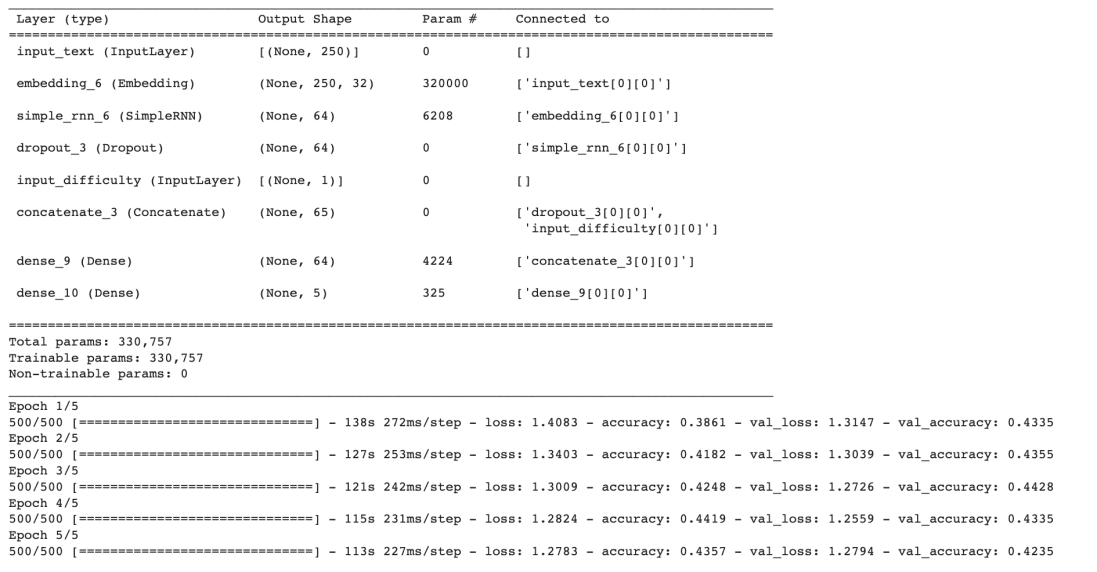

###Model's performance for difficulty rating

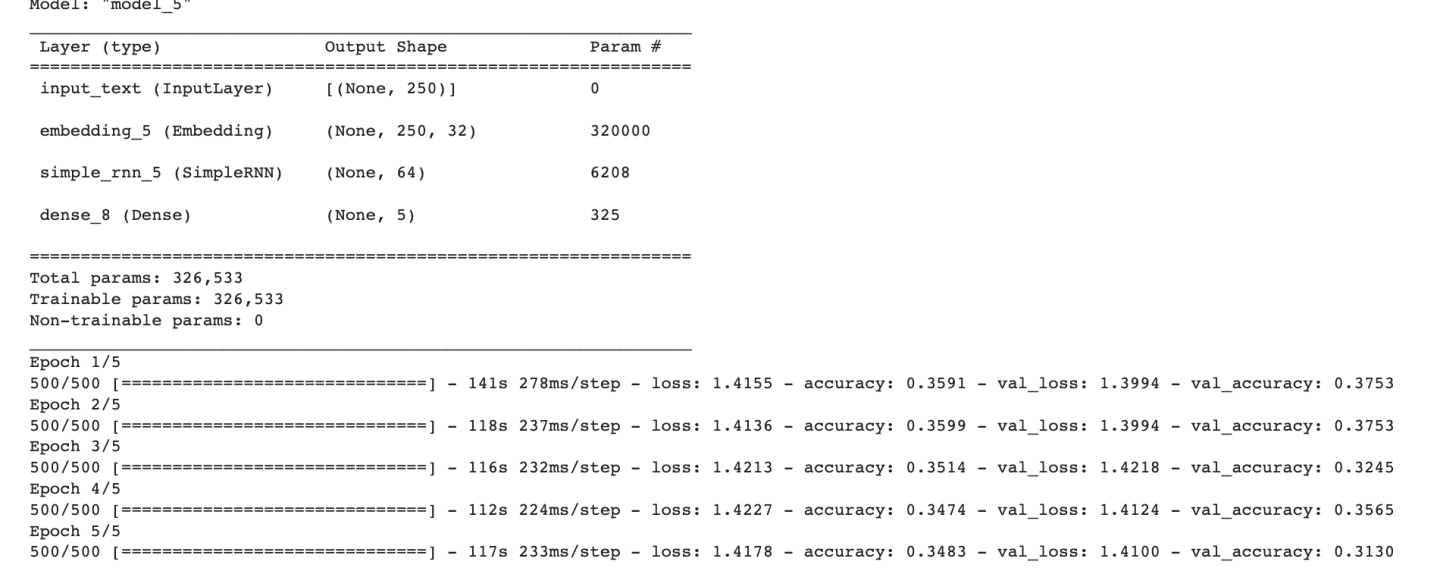